In [26]:
import re
import string
import json
import numpy as np
import pickle

import pandas as pd
import sqlite3

import tensorflow
tensorflow.config.experimental.list_physical_devices('GPU')
from keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json
from keras.utils.data_utils import pad_sequences

In [89]:
data = pd.read_csv('data.csv', encoding='iso-8859-1', error_bad_lines=False) 

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1.0,1.0,0.0,0.0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0.0,0.0,1.0,0.0


In [91]:
data.groupby(['Abusive']).agg({'Tweet':['count']})

,Tweet
,count
Abusive,
0,11697
1,7207


In [92]:
data.groupby(['HS']).agg({'Tweet':['count']})

,Tweet
,count
HS,
0,10928
1,7976


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18905 entries, 0 to 18904
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tweet          18904 non-null  object 
 1   HS             18905 non-null  int64  
 2   Abusive        18905 non-null  int64  
 3   HS_Individual  18905 non-null  int64  
 4   HS_Group       18905 non-null  int64  
 5   HS_Religion    18905 non-null  int64  
 6   HS_Race        18905 non-null  int64  
 7   HS_Physical    18905 non-null  int64  
 8   HS_Gender      18905 non-null  int64  
 9   HS_Other       18904 non-null  float64
 10  HS_Weak        18904 non-null  float64
 11  HS_Moderate    18904 non-null  float64
 12  HS_Strong      18904 non-null  float64
dtypes: float64(4), int64(8), object(1)
memory usage: 1.9+ MB


#CLEANSING

In [30]:
db = sqlite3.connect('dbp.db', check_same_thread=False)
db.text_factory = bytes
mycursor = db.cursor()

In [31]:
#Baca Table Kamus Alay
query = "select * from kamus_alay"
kamusalay = pd.read_sql_query(query, db)
kamusalay['hasil clean'] = kamusalay['hasil clean'].str.decode('utf-8')
kamusalay['kata alay'] = kamusalay['kata alay'].str.decode('utf-8')

In [32]:
alay_dict_map = dict(zip(kamusalay['kata alay'], kamusalay['hasil clean']))
def replace_kamus_alay(text):
    for word in alay_dict_map:
        return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

#Ubah text menjadi lower
def lower(text):
    return text.lower()

def hapuskarakter(text):
    text = re.sub('\n',' ', text)
    text = re.sub('rt',' ', text)
    text = re.sub('user',' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text)
    text = re.sub('  +',' ', text)
    return text

def cleansing(text):
    text = lower(text)
    text = hapuskarakter(text)
    text = replace_kamus_alay(text)
    return text

In [33]:
hasil = 'positive'

In [34]:
df1 = data[['Tweet']]

In [35]:
df1.head()

,Tweet
0,- disaat semua cowok berusaha melacak perhatia...
1,RT USER: USER siapa yang telat ngasih tau elu?...
2,"41. Kadang aku berfikir, kenapa aku tetap perc..."
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...
4,USER USER Kaum cebong kapir udah keliatan dong...


In [36]:
df1['Hasil'] = 'positive'

<ipython-input-36-b4a8957396f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Hasil'] = 'positive'


#LSTM


In [37]:
with open('tokenizer.json') as f:
        data = json.load(f)
        tokenizer = tokenizer_from_json(data)

In [38]:
loaded_model = tensorflow.keras.models.load_model('Model_LSTM.h5', compile=False)

In [39]:
def process_csv_lstm(input_file):
    first_column = input_file.iloc[:, 0]
    print(first_column)
    i=0
    eror=0
    for tweet in first_column:
        try:
          tweet = cleansing(tweet)
          pred_sentiment(tweet)
          classes = pred_sentiment(tweet)
          hasil = pred(classes)
          df1['Hasil'][i] = hasil
        except:
          eror+=1
          
        i+=1

In [40]:
def pred_sentiment(string):
    
    string = cleansing(string)
    text = [string]

    sekuens_x = tokenizer.texts_to_sequences(text)
    padded_x = pad_sequences(sekuens_x)

    classes = loaded_model.predict(padded_x, batch_size=10)

    return classes[0]

In [41]:
def pred(classes):
    hasil=""
    if classes[0] == classes.max():
        hasil = "negative"
        return hasil
    if classes[1] == classes.max():
        hasil = "neutral"
        return hasil
    if classes[2] == classes.max():
        hasil = "positif"
        return hasil

In [42]:
process_csv_lstm(df1)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 68ms/step


In [43]:
df1 = df1.replace('positive', 'positif')
df1.head()

,Tweet,Hasil
0,- disaat semua cowok berusaha melacak perhatia...,negative
1,RT USER: USER siapa yang telat ngasih tau elu?...,neutral
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",positif
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,negative
4,USER USER Kaum cebong kapir udah keliatan dong...,negative


In [45]:
df1.groupby(['Hasil']).agg({'Tweet':['count']})

,Tweet
,count
Hasil,
negative,8240
neutral,6993
positif,3671


#NN

In [46]:
df2 = df1[['Tweet']]

In [47]:
df2['Hasil'] = 'positive'
df2.head()

,Tweet,Hasil
0,- disaat semua cowok berusaha melacak perhatia...,positive
1,RT USER: USER siapa yang telat ngasih tau elu?...,positive
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,positive
4,USER USER Kaum cebong kapir udah keliatan dong...,positive


In [93]:
df2.head()

,Tweet,Hasil
0,- disaat semua cowok berusaha melacak perhatia...,negative
1,RT USER: USER siapa yang telat ngasih tau elu?...,negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",positive
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,negative
4,USER USER Kaum cebong kapir udah keliatan dong...,negative


In [48]:
with open('model_nn.pkl', 'rb') as f: 
    model_nn = pickle.load(f)

with open('countvect.pkl', 'rb') as g: 
    count_vect_nn = pickle.load(g)

In [53]:
def process_csv_nn(input_file):
    first_column = input_file.iloc[:, 0]
    i=0
    for tweet in first_column:
        try:
          tweet = cleansing(tweet)
          text = count_vect_nn.transform([tweet])
          result = model_nn.predict(text)[0]
          hasil=str(result)
          df2['Hasil'][i] = hasil
        except:
          pass
        i+=1

In [54]:
process_csv_nn(df2)

#GRAFIK HASIL ANALISIS

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

##Hasil analisis NN


In [55]:
df2.groupby(['Hasil']).agg({'Tweet':['count']})

,Tweet
,count
Hasil,
negative,13583
neutral,2991
positive,2330


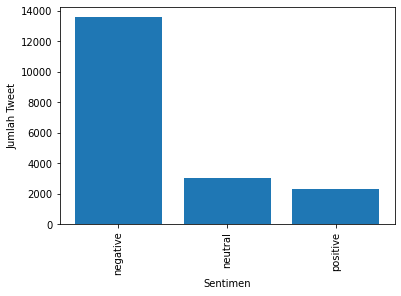

In [86]:
product_group = df2.groupby('Hasil')
quantity_ordered = product_group.count()['Tweet']

produk = [produk for produk, df2 in product_group]
plt.bar(produk, quantity_ordered)
plt.ylabel('Jumlah Tweet')
plt.xlabel('Sentimen')
plt.xticks(produk, rotation='vertical', size=10)
plt.savefig('ns.png', bbox_inches='tight')
plt.show()

##Hasil Analisis LSTM

In [56]:
df1.groupby(['Hasil']).agg({'Tweet':['count']})

,Tweet
,count
Hasil,
negative,8240
neutral,6993
positif,3671


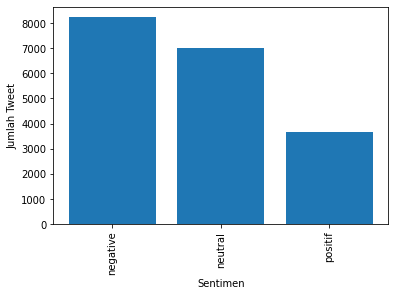

In [87]:
product_group = df1.groupby('Hasil')
quantity_ordered = product_group.count()['Tweet']

produk = [produk for produk, df2 in product_group]
plt.bar(produk, quantity_ordered)
plt.ylabel('Jumlah Tweet')
plt.xlabel('Sentimen')
plt.xticks(produk, rotation='vertical', size=10)
plt.savefig('LSTM.png', bbox_inches='tight')
plt.show()

#KESIMPULAN

Pada data mentah, terdapat 7000 lebih Tweet yang mengandung kata Abusive dan Hatespeech dimana 7000 Tweet tersebut mengindikasikan kalimat negatif. Pada hasil prediksi dengan Neural Network terdapat hampir 14000 kalimat negatif, sedangkan pada hasil prediksi dengan LSTM terdapat sekitar 8000 kalimat negatif. Artinya model LSTM mengeluarkan hasil prediksi yang lebih mendekati ke data sebenarnya sehingga model LSTM mengindikasikan akurasi yang lebih tinggi daripada model Neural Network.